# Overview
This is my attempt to solve the 2nd assignment of the Digital Signal Processing course offered at Innopolis University

# Preeliminary: Imports and exploring the data

In [1]:
import requests
import os 
from scipy.io import wavfile
import noisereduce as nr

from random import sample
import random
random.seed(69)


In [2]:
! pip install noisereduce


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# downloading the file with the helper functions
file_url = 'https://raw.githubusercontent.com/ayhem18/Towards_Data_Science/main/signal_processing/uni_course/assignment_1/linear_sinusoidal_modeling.py'
r = requests.get(file_url, allow_redirects=True)

file_name = "linear_sinusoidal_modeling"

if not os.path.isfile(os.path.join(os.getcwd(), file_name)):
    with open(file_name + '.py', 'wb') as f:
        f.write(r.content)


In [4]:
# first let's start with listening to some audio files
import os

barbie_path = os.path.join(os.getcwd(), 'barbie_vs_puppy', 'barbie')
puppy_path = os.path.join(os.getcwd(), 'barbie_vs_puppy', 'puppy')
b_files = [os.path.join(barbie_path, file_name) for file_name in os.listdir(barbie_path)]
p_files = [os.path.join(puppy_path, file_name) for file_name in os.listdir(puppy_path)]

num_samples = 3
b_sample = sample(b_files, num_samples)
p_sample = sample(p_files, num_samples)


In [5]:
from thinkdsp import read_wave
for b in b_sample:
    display(read_wave(b).make_audio())

for p in p_sample:
    display(read_wave(p).make_audio())

# Filtering silence and reducing the noise

In [6]:
# let's first create a filtered, noise-reduced version of our dataset
# this one will augmented with several techniques

# parent directory for clean data
clean_path = os.path.join(os.getcwd(), 'clean_data') 
clean_path_barbie = os.path.join(clean_path,  'barbie')
clean_path_puppy = os.path.join(clean_path, 'puppy')

os.makedirs(clean_path, exist_ok=True)
os.makedirs(clean_path_barbie, exist_ok=True)
os.makedirs(clean_path_puppy, exist_ok=True)


In [7]:
from linear_sinusoidal_modeling import filter_wave
# iterate through puppy data


# only run this code if the clean_puppy directory is empty
if not os.listdir(clean_path_puppy):

    for p_path, p_file in zip(p_files, os.listdir(puppy_path)):
        # p_path is the path from where the file should be read
        w = read_wave(p_path)
        w1 = filter_wave(w)
        # display(w1.make_audio())
        # p_file represents only the last part of the path: it should be the same for easier comparison
        w1.write(os.path.join(clean_path_puppy, f'clean_{p_file}')) 

    # now reduce the noise after filtering
    for p_file in os.listdir(clean_path_puppy):
        p = os.path.join(clean_path_puppy, p_file)
        rate, data = wavfile.read(p)
        # perform noise reduction
        reduced_noise = nr.reduce_noise(y=data, sr=rate)
        wavfile.write(p, rate, reduced_noise)


In [8]:
# iterate through barbie data

if not os.listdir(clean_path_barbie):

    for path, file in zip(b_files, os.listdir(barbie_path)):
        # p_path is the path from where the file should be read
        w = read_wave(path)
        w1 = filter_wave(w)
        # display(w1.make_audio())
        # p_file represents only the last part of the path: it should be the same for easier comparison
        w1.write(os.path.join(clean_path_barbie, f'clean_{file}')) 


    # now reduce the noise after filtering
    for file in os.listdir(clean_path_barbie):
        p = os.path.join(clean_path_barbie, file)
        rate, data = wavfile.read(p)
        # perform noise reduction
        reduced_noise = nr.reduce_noise(y=data, sr=rate)
        wavfile.write(p, rate, reduced_noise)


In [9]:
# displaying the difference between the initial data and the cleaned one


for p, cp in zip(os.listdir(barbie_path)[:3], os.listdir(clean_path_barbie)[:3]):
    print("#" * 100)
    org = read_wave(os.path.join(barbie_path, p))
    clean = read_wave(os.path.join(clean_path_barbie, cp))
    display(org.make_audio())
    display(clean.make_audio())

####################################################################################################


####################################################################################################


####################################################################################################


# Augmenting data: using Linear Sinusoidal Modeling

In [10]:
from linear_sinusoidal_modeling import find_passes
from linear_sinusoidal_modeling import approximate_wave

In [11]:
# let's create the directory 
augmented_data = os.path.join(os.getcwd(), 'augmented_data')
modeled_data = os.path.join(augmented_data, 'modeled_data')
barbie_modeled_data =  os.path.join(modeled_data, 'barbie')
puppy_modeled_data = os.path.join(modeled_data, 'puppy')
os.makedirs(modeled_data, exist_ok=True)
os.makedirs(barbie_modeled_data, exist_ok=True)
os.makedirs(puppy_modeled_data, exist_ok=True)


Before approximating the dataset using a linear combination of basic signals, Applying a number of filter passes is quite recommended as it would both:
1. speed up the approximation process
2. improve the performance.

In order to automatically a unified filter on the puppy and barbie audios, I make use of the ***find_passes*** function described as follows:
1. iterating through each audio in the puppy / barbie dataset
2. For each audio, the spectrum is generated. For each present frequency, two main steps take place:
    * the frequency is rounded to its integer part
    * each resulting frequency is mapped to the sum of the norms of its associated amplitudes
3. Succeeding iterating across the entire dataset, we now have a dictionary of frequencies and their average magnitiude in one puppy/barbie audio 
4. Applying the IQR rule for outliers detection, frequecies not falling within the produced bounds are filtered using high and low passes


In [12]:
# let's first find suitable values for the passes for the barbie data

barbie_waves = [os.path.join(clean_path_barbie, b) for b in os.listdir(clean_path_barbie)]
puppy_waves = [os.path.join(clean_path_puppy, p) for p in os.listdir(clean_path_puppy)]


## Model Barbie Data

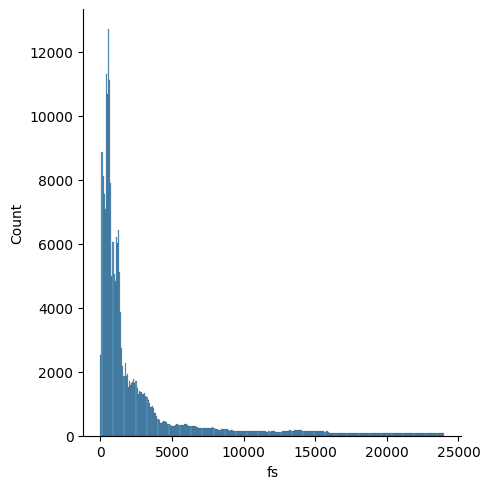

In [13]:
min_freq_barbie, max_freq_barbie = find_passes(barbie_waves, save='barbie_passes.txt')

In [14]:
# run this code only if the barbie_modeled_data directory is empty

if not os.listdir(barbie_modeled_data):
    # let's create the new dataset
    for barbie_file_name in os.listdir(clean_path_barbie):
        file_name = os.path.join(clean_path_barbie, barbie_file_name)
        # extract the wave
        wave = read_wave(file_name)
        # approximate the wave
        approx = approximate_wave(wave, low_pass = max_freq_barbie, high_pass=min_freq_barbie, display_final=False, display_result=True)
        # save it in the corresponding 
        new_file_name = os.path.join(barbie_modeled_data, f'augmented_{barbie_file_name}')
        approx.write(new_file_name)


## Model the puppy data

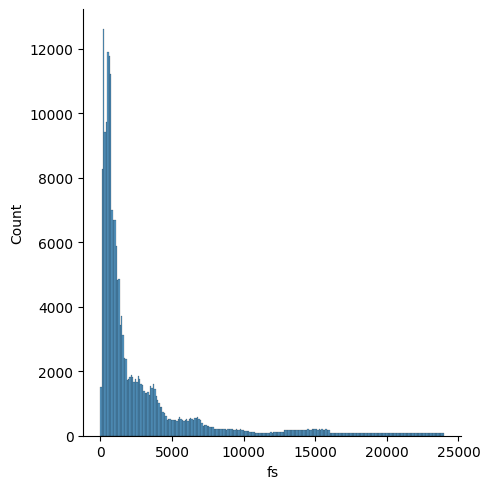

In [15]:
min_freq_puppy, max_freq_puppy = find_passes(puppy_waves, save='puppy_passes.txt')

In [16]:
# run this code only is the puppy_modeled_data is empty

if not os.listdir(puppy_modeled_data):
    for puppy_file_name in os.listdir(clean_path_puppy):
        file_name = os.path.join(clean_path_puppy, puppy_file_name)
        # extract the wave
        wave = read_wave(file_name)
        # approximate the wave
        approx = approximate_wave(wave, low_pass = max_freq_puppy, high_pass=min_freq_puppy, display_final=False, display_result=True )
        # save it in the corresponding 
        new_file_name = os.path.join(puppy_modeled_data, 'augmented_{puppy_file_name}')
        approx.write(new_file_name)


# Augmenting Data with Noises

In [17]:
from thinkdsp import Wave
from thinkdsp import Noise
from thinkdsp import PinkNoise
from thinkdsp import UncorrelatedGaussianNoise

import numpy as np

def add_pink_noise(wave, beta:float, is_file:bool=False, snr:float=50, display_result=True):
    """This function given an initial wave, noise signal and a signal to ration noise,
      will generate a new wave by adding the passed noise with the specified snr

    Args:
        wave (Wave or str): the wave to which the noise is added or its path
        noise (Noise): a noise signal: the one to add to the wave
        is_file (bool, optional): whether the wave is to be read from a file. Defaults to False.
        snr (float, optional): abbreviation of sigal to noise ratio . Defaults to 20.
    """
    # first calculate the amplitude of the initial wave
    if is_file:
        wave = read_wave(wave)
    
    amp_wave = np.max(wave.ys)
    # let's calculate the amplitude of the noise signal using snr

    noise_amp = amp_wave / np.sqrt(snr)
    
    # creating a noise signal
    noise_signal = PinkNoise(amp=noise_amp, beta=beta)
    # creating the instance using the initial wave parameters
    noise_wave = noise_signal.make_wave(start=wave.start, duration=wave.duration, framerate=wave.framerate)
    # time to add the noise
    result_wave = noise_wave + wave

    if display_result:
        print(f"THE PINK WAVE WITH NOISE {beta}:")
        display(result_wave.make_audio())
        print()

    return result_wave

def add_guassian_noise(wave, is_file:bool=False, snr:float=20, display_result=True):
    """This function given an initial wave, noise signal and a signal to ration noise,
      will generate a new wave by adding the passed noise with the specified snr

    Args:
        wave (Wave or str): the wave to which the noise is added or its path
        is_file (bool, optional): whether the wave is to be read from a file. Defaults to False.
        snr (float, optional): abbreviation of sigal to noise ratio . Defaults to 20.
    """
    # first calculate the amplitude of the initial wave
    if is_file:
        wave = read_wave(wave)
    
    amp_wave = np.max(wave.ys)
    # let's calculate the amplitude of the noise signal using snr

    noise_amp = amp_wave / np.sqrt(snr)
    
    # creating a noise signal
    noise_signal = UncorrelatedGaussianNoise(noise_amp)
    # creating the instance using the initial wave parameters
    noise_wave = noise_signal.make_wave(start=wave.start, duration=wave.duration, framerate=wave.framerate)
    # time to add the noise
    result_wave = noise_wave + wave
    
    # display if needed
    if display_result:
        print("THE GUASSIAN WAVE:")
        display(result_wave.make_audio())
        print()


    return result_wave

In [18]:
# let's create the dataset for the noise dataset

# let's create the directory 


noisy_data = os.path.join(augmented_data, 'noisy_data')
barbie_noisy_data =  os.path.join(noisy_data, 'barbie')
puppy_noisy_data = os.path.join(noisy_data, 'puppy')
os.makedirs(noisy_data, exist_ok=True)
os.makedirs(barbie_noisy_data, exist_ok=True)
os.makedirs(puppy_noisy_data, exist_ok=True)


In [19]:
# run this code only when the corresponding directory is empty
if not os.listdir(puppy_noisy_data):
    # generate different pink noises
    for b in np.linspace(0, 2, 10):
        for puppy_file_name in os.listdir(clean_path_puppy):
            file_name = os.path.join(clean_path_puppy, puppy_file_name)
            # extract the wave
            noise_wave = add_pink_noise(file_name, is_file=True, beta=b, display_result=False)
            # save it in the corresponding 
            new_file_name = os.path.join(puppy_noisy_data, f'pink_noise_{round(b, 3)}_{puppy_file_name}')
            noise_wave.write(new_file_name)
            # add the guassian one as well
            guassian_wave = add_guassian_noise(file_name, is_file=True, display_result=False)
            guassian_wave.write(os.path.join(puppy_noisy_data, f'guassian_noise_{puppy_file_name}'))    

In [20]:
if not os.listdir(barbie_noisy_data):
    # generate different pink noises
    for b in np.linspace(0, 2, 11):
        for barbie_file_name in os.listdir(clean_path_barbie):
            file_name = os.path.join(clean_path_barbie, barbie_file_name)
            # extract the wave
            noise_wave = add_pink_noise(file_name, is_file=True, beta=b, display_result=False)
            # save it in the corresponding 
            new_file_name = os.path.join(barbie_noisy_data, f'pink_noise_{round(b, 3)}_{barbie_file_name}')
            noise_wave.write(new_file_name)
            # add the guassian one as well
            guassian_wave = add_guassian_noise(file_name, is_file=True, display_result=False)
            guassian_wave.write(os.path.join(barbie_noisy_data, f'guassian_noise_{barbie_file_name}'))    

# Group All Data into a single folder

## Audio Data

In [21]:
# let's first group all the data in one folder 

all_data_dir_audio = os.path.join(os.getcwd(), 'all_data_audio')
barbie_audio = os.path.join(all_data_dir_audio, 'barbie')
puppy_audio = os.path.join(all_data_dir_audio, 'puppy')

os.makedirs(all_data_dir_audio,  exist_ok=True)
os.makedirs(barbie_audio, exist_ok=True)
os.makedirs(puppy_audio, exist_ok=True)

puppy_dirs = [puppy_path, clean_path_puppy, puppy_modeled_data, puppy_noisy_data]
barbie_dirs = [barbie_path, clean_path_barbie, barbie_modeled_data, barbie_noisy_data]

In [22]:
import shutil

def move_directory_to_directory(src_dir: str, des_dir: str):
    assert os.path.isdir(src_dir) and os.path.isdir(des_dir)
    for file_name in os.listdir(src_dir):
        src_path = os.path.join(src_dir, file_name)
        des_path = os.path.join(des_dir, file_name)
        shutil.copy(src_path, des_path)

# let's move the directories accordingly
for pdir in puppy_dirs:
    move_directory_to_directory(pdir, puppy_audio)
for bdir in barbie_dirs:
    move_directory_to_directory(bdir, barbie_audio)

In [23]:

total_len = np.sum([len(os.listdir(pdir)) for pdir in puppy_dirs])
all_p_dir = len(os.listdir(puppy_audio))
assert total_len == all_p_dir

In [24]:
total_len = np.sum([len(os.listdir(pdir)) for pdir in barbie_dirs])
all_p_dir = len(os.listdir(barbie_audio))
assert total_len == all_p_dir

## Images Data: spectograms

In [29]:
# let's make the directory for the images
all_data_image = os.path.join(os.getcwd(), 'all_data_image')
barbie_images = os.path.join(all_data_image, 'barbie')
puppy_images = os.path.join(all_data_image, 'puppy')

os.makedirs(all_data_image, exist_ok=True)
os.makedirs(barbie_images, exist_ok=True)
os.makedirs(puppy_images, exist_ok=True)

FIGSIZE = (8, 8)

In [30]:
# as the number of segments is not known for us, we will 3 different values to cover different cases
import matplotlib.pyplot as plt

if not os.listdir(puppy_images):
    count_puppy = 0
    for v in range(9, 12):
        for pfile in os.listdir(puppy_audio):
            path = os.path.join(puppy_audio, pfile)
            wave = read_wave(path)
            # create the specto
            s = wave.make_spectrogram(seg_length= 2 ** v)
            # plot it with a predefined size
            s.plot()
            # clear the plot to avoid accumulating the images
            plt.axis("off")   # turns off axes
            plt.savefig(os.path.join(puppy_images, f'puppy_{count_puppy}') , bbox_inches='tight', pad_inches = 0)
            plt.clf()
            count_puppy += 1
        
    

In [31]:
print(len(os.listdir(puppy_audio)))
print(len(os.listdir(barbie_audio)))

495
600


In [32]:
if not os.listdir(barbie_images):
    count_barbie = 0
    for v in range(9, 12):
        for pfile in os.listdir(barbie_audio):
            path = os.path.join(barbie_audio, pfile)
            wave = read_wave(path)
            # create the specto
            s = wave.make_spectrogram(seg_length= 2 ** v)
            # plot it
            s.plot()
            plt.axis("off")   # turns off axes
            plt.savefig(os.path.join(barbie_images, f'barbie_{count_barbie}') , bbox_inches='tight', pad_inches = 0)
            # clear the plot to avoid accumulating the images
            plt.clf()
            count_barbie += 1
        


In [34]:
print(len(os.listdir(puppy_images)))
print(len(os.listdir(barbie_images)))

1485
1800


## splitting the training data

In [38]:
training = os.path.join(os.getcwd(), 'training')
training_puppy = os.path.join(training, 'puppy')
training_barbie = os.path.join(training, 'barbie')


validation = os.path.join(os.getcwd(), 'validation')
validation_puppy = os.path.join(validation, 'puppy')
validation_barbie = os.path.join(validation, 'barbie')

os.makedirs(training, exist_ok=True)
os.makedirs(training_puppy, exist_ok=True)
os.makedirs(training_barbie, exist_ok=True)

os.makedirs(validation, exist_ok=True)
os.makedirs(validation_puppy, exist_ok=True)
os.makedirs(validation_barbie, exist_ok=True)



In [39]:
from sklearn.model_selection import train_test_split

p_train, p_val = train_test_split(os.listdir(puppy_images), random_state=69, test_size=0.2)
b_train, b_val = train_test_split(os.listdir(barbie_images), random_state=69, test_size=0.2)


In [40]:
# move training data and validation data seperately

for t in p_train: 
    src_path_1 = os.path.join(puppy_images, t)
    des_path_1 = os.path.join(training_puppy, t)
    shutil.copy(src_path_1, des_path_1)

for v in p_val:        
    src_path_2 = os.path.join(puppy_images, v)
    des_path_2 = os.path.join(validation_puppy, v)
    shutil.copy(src_path_2, des_path_2)


In [41]:
for t in b_train:
    src_path_1 = os.path.join(barbie_images, t)
    des_path_1 = os.path.join(training_barbie, t)
    shutil.copy(src_path_1, des_path_1)

for v in b_val:
    src_path_2 = os.path.join(barbie_images, v)
    des_path_2 = os.path.join(validation_barbie, v)
    shutil.copy(src_path_2, des_path_2)